# Postprocessing

The postprocessing module provides functions to combine CMIP6 datasets (provided in a dictionary) based on their dataset attributes. We provide some general, highly customizable function `combine_datasets`, but also some simpler wrappers for often-used functionality like merging variables, concatenating members and even parsing metric coordinates (given in a seperate dictionary of datasets).

This functionality overlaps to a degree with the approach taken in [intake-esm](https://intake-esm.readthedocs.io/en/latest/), but provides more flexibility to predetermine the order of operations and crucially, custom functions can be applied at every step. 

> You can still use intake-esm, but for this functionality to work please specify `aggregate=False` as below.

In [2]:
# lets start by loading a few example dataset
from cmip6_preprocessing.utils import google_cmip_col
from cmip6_preprocessing.preprocessing import combined_preprocessing

col = google_cmip_col()
experiment_id='historical'
source_id = ['CanESM5-CanOE', 'GFDL-ESM4']
kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True
    },
    'aggregate':False,
    'preprocess':combined_preprocessing
}

cat_data = col.search(
    source_id=source_id,
    experiment_id=experiment_id,
    grid_label='gn',
    variable_id=['tos', 'zos']
)
ddict = cat_data.to_dataset_dict(**kwargs)
list(ddict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/tos/gn/v20190429/.nan.20190429',
 'CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.zos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/zos/gn/v20190429/.nan.20190429',
 'CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/tos/gn/v20190429/.nan.20190429',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r2i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r2i1p1f1/Omon/tos/gn/v20180701/.nan.20180701',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.zos.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/zos/gn/v20190726/.nan.20190726',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/tos/gn/v20190726/.nan.20190726',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r3i1p1f1

You can see that the dictionary contains data from different models, ensemble members, and two variables: `zos` (sea surface height) and `tos` (sea surface temperature).

Lets go through a couple of steps here to reduce these to two `model` datasets (each model should be one xarray dataset with both variables and concatenated members).

### Merging variables

First lets merge the variables (currently in a dataset each) into a single dataset.

In [3]:
from cmip6_preprocessing.postprocessing import merge_variables

ddict_merged = merge_variables(ddict)
list(ddict_merged.keys())

['CanESM5-CanOE.gn.historical.Omon.r2i1p2f1',
 'CanESM5-CanOE.gn.historical.Omon.r3i1p2f1',
 'CanESM5-CanOE.gn.historical.Omon.r1i1p2f1',
 'GFDL-ESM4.gn.historical.Omon.r2i1p1f1',
 'GFDL-ESM4.gn.historical.Omon.r1i1p1f1',
 'GFDL-ESM4.gn.historical.Omon.r3i1p1f1']

The keys have been replaced by an identifier based on the unique attributes that differntiate each of the datasets, but not the variable name anymore. 

In [4]:
# check if the merging worked
ddict_merged['GFDL-ESM4.gn.historical.Omon.r2i1p1f1']

<xarray.Dataset>
Dimensions:        (bnds: 2, time: 1980, vertex: 4, x: 720, y: 576)
Coordinates:
  * bnds           (bnds) float64 1.0 2.0
    lat            (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x              (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y              (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
Data variables:
    tos            (time, y, x) float32 dask.array<chunksize=(64, 576, 720), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(61, 576, 720), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    variant_info:           N/A
    variant_label:          r2i1p1f1
    version_id:             v20180701
    intake_esm_varname:     None
    original_key:           CMIP.NOAA-GFDL.GFDL-ESM4.historical.r2i1p1f1.Omon...

You can see that the datasets now in fact contain both variables in a single dataset.

Lets keep going. Since these members are all of the same length (might not be true for all CMIP6 models!) we can simply concatenate them along a new dimension:

In [5]:
from cmip6_preprocessing.postprocessing import concat_members

ddict_concat = concat_members(ddict_merged)
print(list(ddict_concat.keys()))
ddict_concat['GFDL-ESM4.gn.historical.Omon']

['CanESM5-CanOE.gn.historical.Omon', 'GFDL-ESM4.gn.historical.Omon']


,Array,Chunk
Bytes,9.85 GB,106.17 MB
Shape,"(3, 1980, 576, 720)","(1, 64, 576, 720)"
Count,531 Tasks,135 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,9.85 GB,101.19 MB
Shape,"(3, 1980, 576, 720)","(1, 61, 576, 720)"
Count,300 Tasks,99 Chunks
Type,float32,numpy.ndarray


Now we have only one dataset per model and experiment, enableing us to apply some sort of analysis that depends on both variables easily.
Here we plot the average SST where the SSH is smaller than 0 just for demonstration purposes.

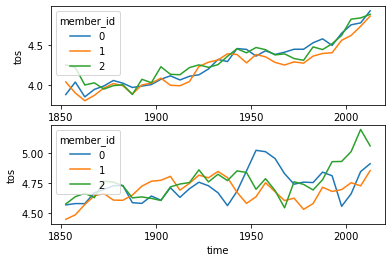

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,4])
for i, (name, ds) in enumerate(ddict_concat.items()):
    data = ds.tos.where(ds.zos<0).mean(['x','y'])
    plt.subplot(2,1,i+1)
    data.coarsen(time=12*5).mean().plot(hue='member_id')
    plt.gca().set_title(ds.attrs['source_id'])

## Custom combination functions

There might be cases where the convenience wrappers are not exactly flexible enough. In that case you can always use `combine_datasets` with a custom function. This function takes a list of 'matched' xarray.Datasets as input. The matching is done by providing the attributes which should be the same in all of the matched datasets.

A common use case could be to pick just any single member from a model. This helps in developing analyses for many models without having to compute all of them at the initial stage.

In [15]:
from cmip6_preprocessing.postprocessing import combine_datasets

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddict_new = combine_datasets(
    ddict_merged,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
ddict_new['CanESM5-CanOE.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (bnds: 2, time: 1980, vertex: 4, x: 360, y: 291)
Coordinates:
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
    lat            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 291, 360), meta=np.ndarray>
Data variables:
    tos            (time, y, x) float32 dask.array<chunksize=(215, 291, 360), meta=np.ndarray>
    zos            (time, y, x) float32 dask.array<chunksize=(208, 291, 360), meta=np.ndarray>
Attributes: (12/52)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his02
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    title:                       CanESM5-CanOE output prepared for CMIP6
    variant_label:               r2i1p2f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          None
    original_key:                CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1...

Cool, now we have a dictionary where each entry only contains one member. This approach can be used to implement a variety of custom functions on matched datasets.

# Combining different grids via interpolation

Not all outputs in CMIP for a specific model are provided on the same grid structure. Especially in the ocean, the native grid `gn` can be quite complex and some variables are regridded to regular lon/lat grids for either convenience or to save storage.

In [2]:
col = google_cmip_col()
cat = col.search(
    variable_id=["thetao", "o2"],
    experiment_id=["historical"],
    source_id=["GFDL-ESM4", "CanESM5-CanOE"],
    table_id=["Omon"],
)
ddict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    aggregate=False,
    preprocess=combined_preprocessing,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [3]:
list(ddict.keys())

['CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429',
 'CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429',
 'CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.o2.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/o2/gn/v20190429/.nan.20190429',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.thetao.gr.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/thetao/gr/v20190726/.nan.20190726',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/thetao/gn/v20190726/.nan.20190726',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.o2.gr.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/o2/gr/v20190726/.nan.20190726',
 'CMIP.CCCma.CanESM5-CanOE

For the CanESM5-CanOE model, all variables are on the native `gn` grid. We could combine the variables simply using the logic from above. But the GFDL-ESM4 model provides oxygen `o2` only on a regridded `gr` grid, while the potential temperature `thetao` is actually available for both grids. If we are fine with using the lower resolution regridded (`gr`) we could just filter for that during the selection, but there are cases where one might want to preserve as much detail as possible, or where another variable is only available on the native grid. In that case we can use [xESMF](https://github.com/pangeo-data/xESMF) to interpolate from one grid to another.

cmip6_preprocessing provides a convenient wrapper which will interpolate non-existing grid labels onto the desired grid:

In [5]:
from cmip6_preprocessing.postprocessing import (
    interpolate_grid_label
)

In [11]:
combined_grids_dict = interpolate_grid_label(ddict, target_grid_label='gn')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
list(combined_grids_dict.keys())

['CanESM5-CanOE.historical.Omon.r3i1p2f1',
 'CanESM5-CanOE.historical.Omon.r2i1p2f1',
 'GFDL-ESM4.historical.Omon.r1i1p1f1',
 'CanESM5-CanOE.historical.Omon.r1i1p2f1']

Ok we can see that apparently the variables have been combined for each model member. Lets take a closer look:

In [9]:
combined_grids_dict['GFDL-ESM4.historical.Omon.r1i1p1f1']

<xarray.Dataset>
Dimensions:        (bnds: 3, lev: 35, time: 1980, vertex: 4, x: 720, y: 576)
Coordinates: (12/14)
  * bnds           (bnds) float64 0.0 1.0 2.0
  * x              (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y              (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
    lat            (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
  * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    ...             ...
    lon_verticies  (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 3), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(2, 576, 720), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(2, 576, 720), meta=np.ndarray>
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(4, 35, 576, 720), meta=np.ndarray>
    o2             (time, lev, y, x) float64 dask.array<chunksize=(13, 35, 576, 720), meta=np.ndarray>
Attributes: (12/41)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    variant_info:           N/A
    variant_label:          r1i1p1f1
    version_id:             v20190726
    intake_esm_varname:     None
    regrid_method:          bilinear

Both data variables have the same shape, and we can confirm that these match the high resolution native grid ouput.

In [10]:
ddict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/thetao/gn/v20190726/.nan.20190726']

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 35, time: 1980, vertex: 4, x: 720, y: 576)
Coordinates: (12/14)
  * bnds           (bnds) float64 1.0 2.0
    lat            (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float32 dask.array<chunksize=(576, 720, 4), meta=np.ndarray>
  * lev            (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(576, 720), meta=np.ndarray>
    ...             ...
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * x              (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * y              (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float32 dask.array<chunksize=(1, 576, 720), meta=np.ndarray>
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(4, 35, 576, 720), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   36500.0
    comment:                 <null ref>
    ...                      ...
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/6e88fbac-ee16-434e-88b4-92bd18c5300...
    version_id:              v20190726
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omo...
    original_key:            CMIP.NOAA-GFDL.GFDL-ESM4.historical.r1i1p1f1.Omo...

As a final check, lets plot some example maps:

CanESM5-CanOE.historical.Omon.r3i1p2f1
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  0.7s


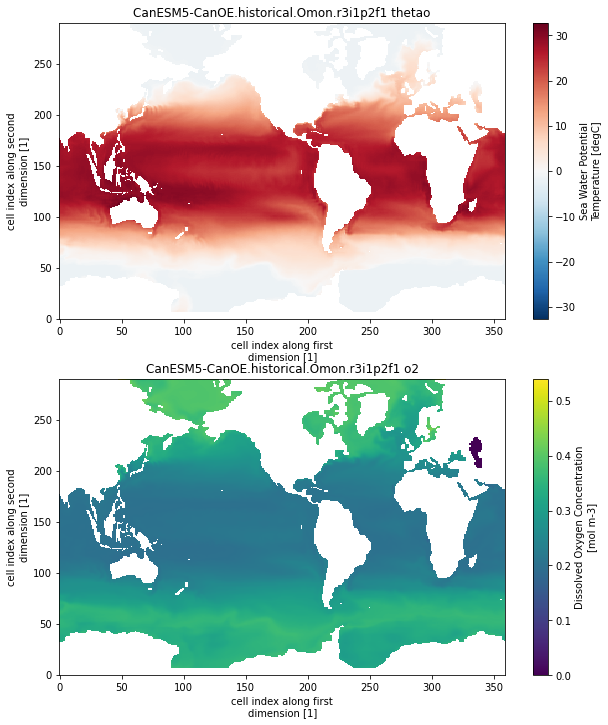

CanESM5-CanOE.historical.Omon.r2i1p2f1
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.8s


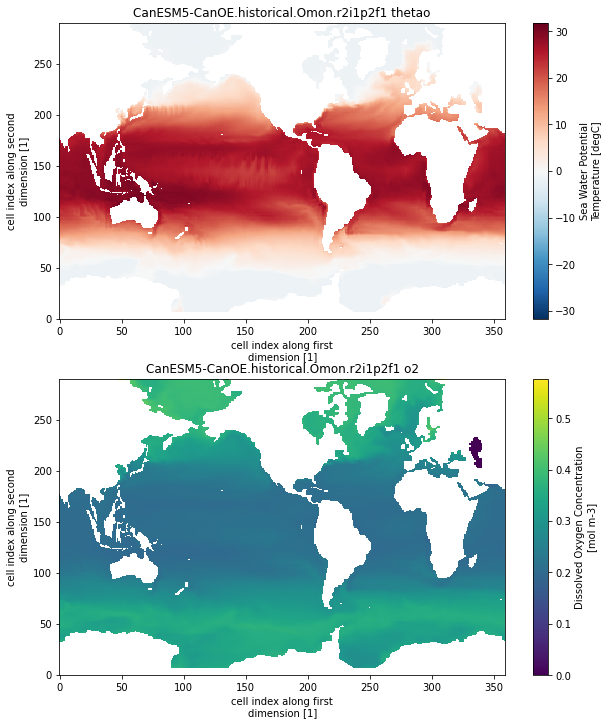

GFDL-ESM4.historical.Omon.r1i1p1f1
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  4.9s


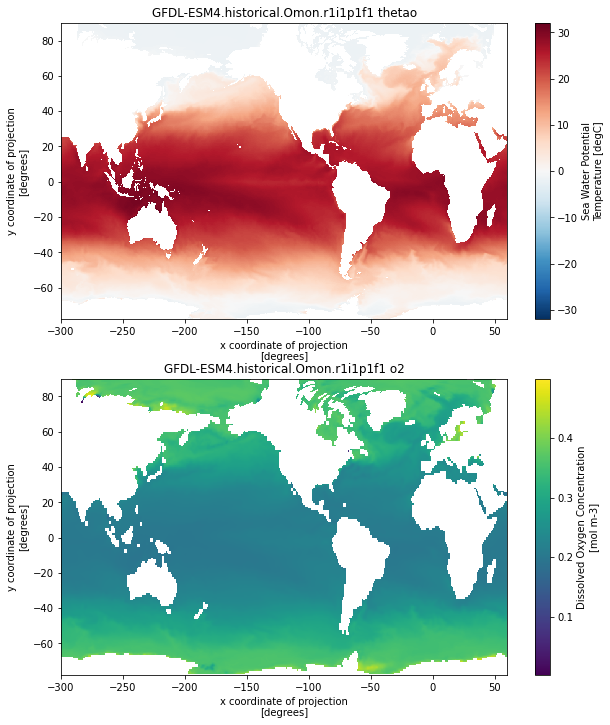

CanESM5-CanOE.historical.Omon.r1i1p2f1
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.8s


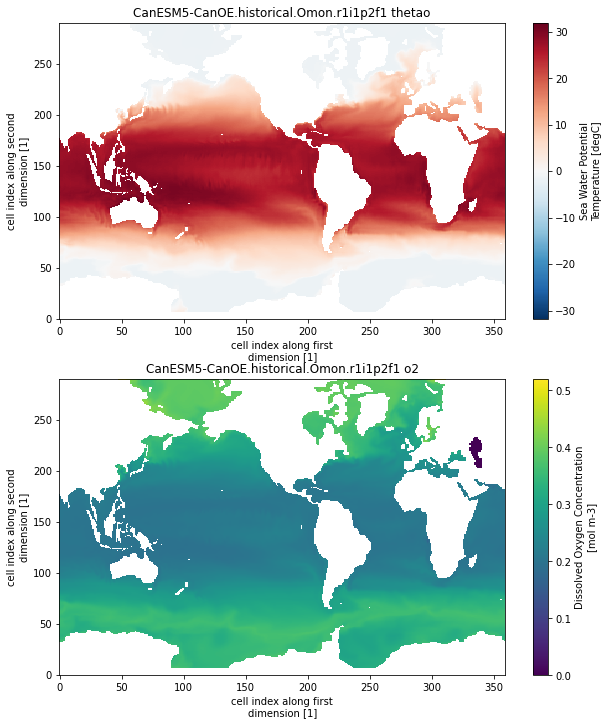

In [13]:
import matplotlib.pyplot as plt

for name, ds in combined_grids_dict.items():
    ds = ds.isel(lev=0, time=0)
    plt.figure(figsize=[10,12])
    plt.subplot(2,1,1)
    ds.thetao.plot()
    plt.title(name+' thetao')
    plt.subplot(2,1,2)
    ds.o2.plot()
    plt.title(name+' o2')
    plt.show()

This looks pretty good! Some notes on the resulting data for further processing:

- The regridding can be computationally expensive, especially for the higher res models. If you run into trouble, you might consider rechunking (along a non horizontal dimenson, e.g. depth or time)

- As of now, we are using the xesmf defaults which can result in inconsistent positions of missing values between variables (check out the coastlines in the GFDL o2 vs thetao above). Make sure to take this into account if you are computing anything that incorporates values near the coastline or globally integrated quantities!

## Handling grid metrics in CMIP6

Using the same logic as before we can start to match grid metrics to model output. 

Almost any analysis with model data involves [grid metrics](https://xgcm.readthedocs.io/en/latest/grid_metrics.html) like cell area, cell volume etc. 
These are essential to compute e.g. global averages since the cells in ocean models are usually not of equal size.

Within the CMIP6 archive grid metrics are stored as seperate variables like `areacello` (horizontal grid area) or `thkcello`(vertical cell thickness), and it can be rather cumbersome to match these. 
`cmip6_preprocessing` has some functions to make this easy, which also offer some options to use metrics from e.g. another experiment in case these are not available (more on that below).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

Lets start by loading a bunch of ocean temperature output into a dictionary of datasets

In [7]:
from cmip6_preprocessing.utils import google_cmip_col
from cmip6_preprocessing.preprocessing import combined_preprocessing

col = google_cmip_col()
experiment_id='historical'
source_id = 'MPI-ESM1-2-LR'
kwargs = {'zarr_kwargs':{'consolidated':True, 'use_cftime':True}, 'aggregate':False, 'preprocess':combined_preprocessing}

cat_data = col.search(source_id=source_id, experiment_id=experiment_id, variable_id='tos')
ddict = cat_data.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


> Note the `aggregate=False` option, which prevents the concatenation of model members in this case.
I have found that in many cases this concatenation can lead to dask performance problems and I currently 
do not recommend it in my workflow. 

Now lets repeat the step, but switch the `variable_id` to a metric of interest, like the cell area.

In [8]:
cat_metric = col.search(source_id=source_id, experiment_id=experiment_id, variable_id='areacello')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


You can see that there are 10 datasets loaded for both the metrics and the actual data. Lets match these up by using `match_metrics`

In [9]:
from cmip6_preprocessing.postprocessing import match_metrics
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'])

You can convince yourself that all the datasets in `ddict_matched` now have a coordinate called `areacello`

In [12]:
ddict_matched['CMIP.MPI-M.MPI-ESM1-2-LR.historical.r1i1p1f1.Oday.tos.gn.gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Oday/tos/gn/v20190710/.nan.20190710']

<xarray.Dataset>
Dimensions:        (bnds: 2, time: 60265, vertex: 4, x: 256, y: 220)
Coordinates:
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 212 213 214 215 216 217 218 219
    lat            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time           (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(30133, 1), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    areacello      (y, x) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
Data variables:
    tos            (time, y, x) float32 dask.array<chunksize=(429, 220, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   0.0
    cmor_version:            3.5.0
    contact:                 cmip6-mpi-esm@dkrz.de
    creation_date:           2019-09-11T14:21:40Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    grid:                    gn
    grid_label:              gn
    history:                 2019-09-11T14:21:40Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Max Planck Institute for Meteorology, Hamburg 20...
    institution_id:          MPI-M
    license:                 CMIP6 model data produced by MPI-M is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        MPI-ESM1-2-LR
    parent_time_units:       days since 1850-1-1 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    project_id:              CMIP6
    realization_index:       1
    realm:                   ocean
    references:              MPI-ESM: Mauritsen, T. et al. (2019), Developmen...
    source:                  MPI-ESM1.2-LR (2017): \naerosol: none, prescribe...
    source_id:               MPI-ESM1-2-LR
    source_type:             AOGCM
    status:                  2020-09-15;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Oday
    table_info:              Creation Date:(09 May 2019) MD5:e6ef8ececc8f3386...
    title:                   MPI-ESM1-2-LR output prepared for CMIP6
    tracking_id:             hdl:21.14100/634f31a7-9841-4bd4-8a87-fcd03ea56e4...
    variable_id:             tos
    variant_label:           r1i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/634f31a7-9841-4bd4-8a87-fcd03ea56e4...
    version_id:              v20190710
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.MPI-M.MPI-ESM1-2-LR.historical.r1i1p1f1.Oda...

So lets put this to use. We can do a plot of properly weighted global sea surface temperature in a few lines now.

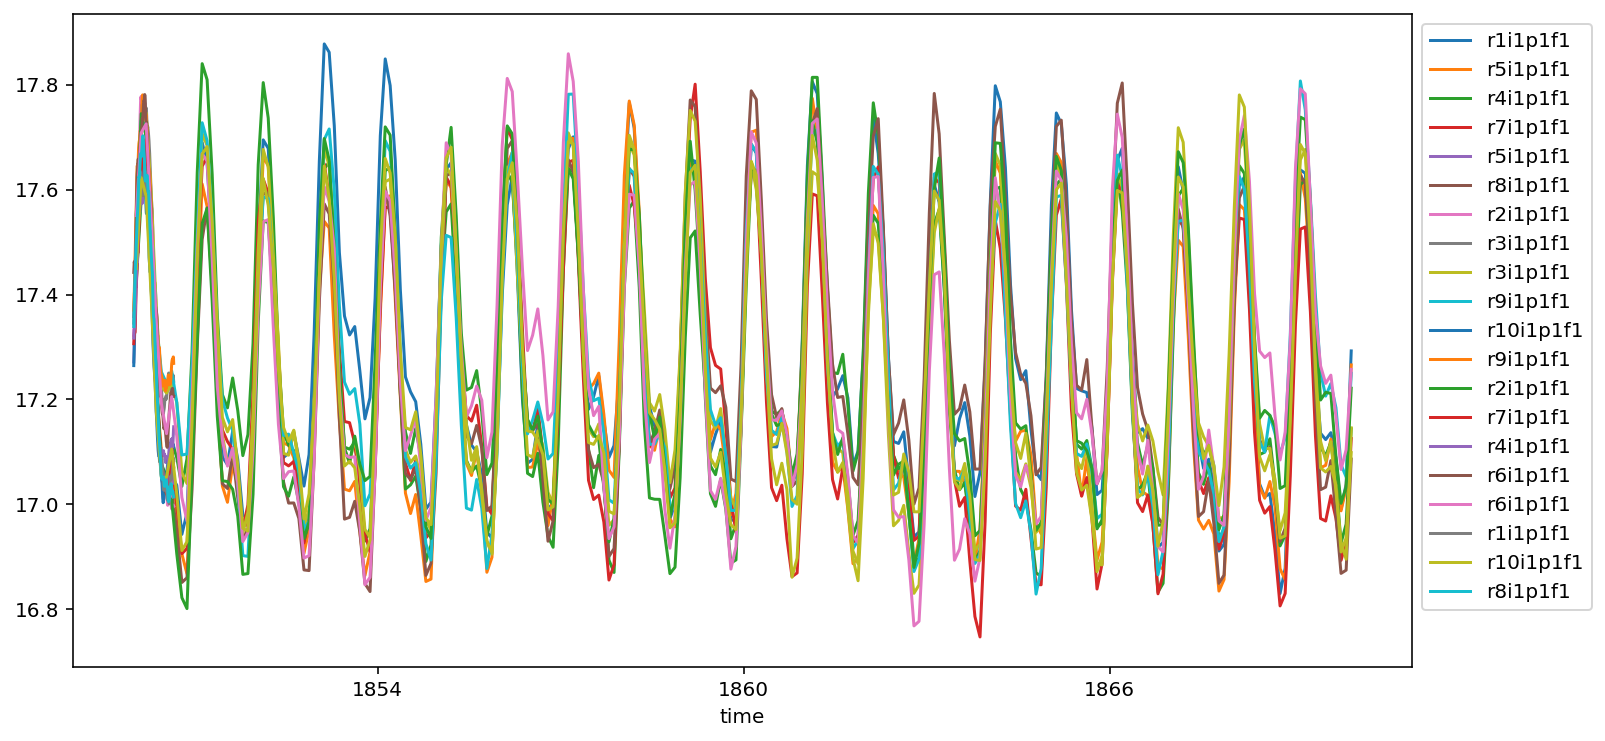

In [15]:
fig, ax = plt.subplots()
for ds in ddict_matched.values():
    # calculate the weighted average over the surface level temperatures
    area = ds.areacello.fillna(0)
    da = ds.tos.isel(time=slice(0,240)).weighted(area).mean(['x','y']).squeeze().load()
    da.plot(ax=ax, label=ds.attrs['variant_label'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

### Match multiple metrics

That was not too bad. Lets continue with an example that needs multiple metrics. For this we will load the full depth potential temperature data (`thetao`), the cell area (`areacello`) and the vertical cell thickness (`thkcello`).

In [18]:
cat_data = col.search(source_id=source_id, experiment_id=experiment_id, variable_id='thetao')
ddict = cat_data.to_dataset_dict(**kwargs)

cat_metric = col.search(source_id=source_id, variable_id=['areacello', 'thkcello'], experiment_id='historical')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)

# Matching 



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Matching both metrics can be done easily

In [19]:
ddict_matched_again = match_metrics(ddict, ddict_metrics, ['areacello', 'thkcello'])
ddict_matched_again['CMIP.MPI-M.MPI-ESM1-2-LR.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Omon/thetao/gn/v20190710/.nan.20190710']

<xarray.Dataset>
Dimensions:        (bnds: 2, lev: 40, time: 1980, vertex: 4, x: 256, y: 220)
Coordinates:
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 248 249 250 251 252 253 254 255
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 212 213 214 215 216 217 218 219
    lat            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * lev            (lev) float64 6.0 17.0 27.0 ... 4.67e+03 5.17e+03 5.72e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(220, 256), meta=np.ndarray>
  * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
    lon_verticies  (y, x, vertex) float64 dask.array<chunksize=(220, 256, 4), meta=np.ndarray>
  * bnds           (bnds) int64 0 1
  * vertex         (vertex) int64 0 1 2 3
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 220, 256), meta=np.ndarray>
    areacello      (y, x) float32 dask.array<chunksize=(220, 256), meta=np.ndarray>
    thkcello       (time, lev, y, x) float32 dask.array<chunksize=(66, 40, 220, 256), meta=np.ndarray>
Data variables:
    thetao         (time, lev, y, x) float32 dask.array<chunksize=(13, 40, 220, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   18262.0
    cmor_version:            3.5.0
    contact:                 cmip6-mpi-esm@dkrz.de
    creation_date:           2019-09-02T13:08:50Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    grid:                    gn
    grid_label:              gn
    history:                 2019-09-02T13:08:50Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Max Planck Institute for Meteorology, Hamburg 20...
    institution_id:          MPI-M
    license:                 CMIP6 model data produced by MPI-M is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        MPI-ESM1-2-LR
    parent_time_units:       days since 1850-1-1 00:00:00
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    project_id:              CMIP6
    realization_index:       2
    realm:                   ocean
    references:              MPI-ESM: Mauritsen, T. et al. (2019), Developmen...
    source:                  MPI-ESM1.2-LR (2017): \naerosol: none, prescribe...
    source_id:               MPI-ESM1-2-LR
    source_type:             AOGCM
    status:                  2020-07-12;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(09 May 2019) MD5:e6ef8ececc8f3386...
    title:                   MPI-ESM1-2-LR output prepared for CMIP6
    tracking_id:             hdl:21.14100/9a791e46-3b24-49f0-a628-66ef71241d7...
    variable_id:             thetao
    variant_label:           r2i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/9a791e46-3b24-49f0-a628-66ef71241d7...
    version_id:              v20190710
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.MPI-M.MPI-ESM1-2-LR.

In order to average temperature over both depth and the whole globe, we need to weight it by cell volume, which is simply the product of area and vertical thickness.

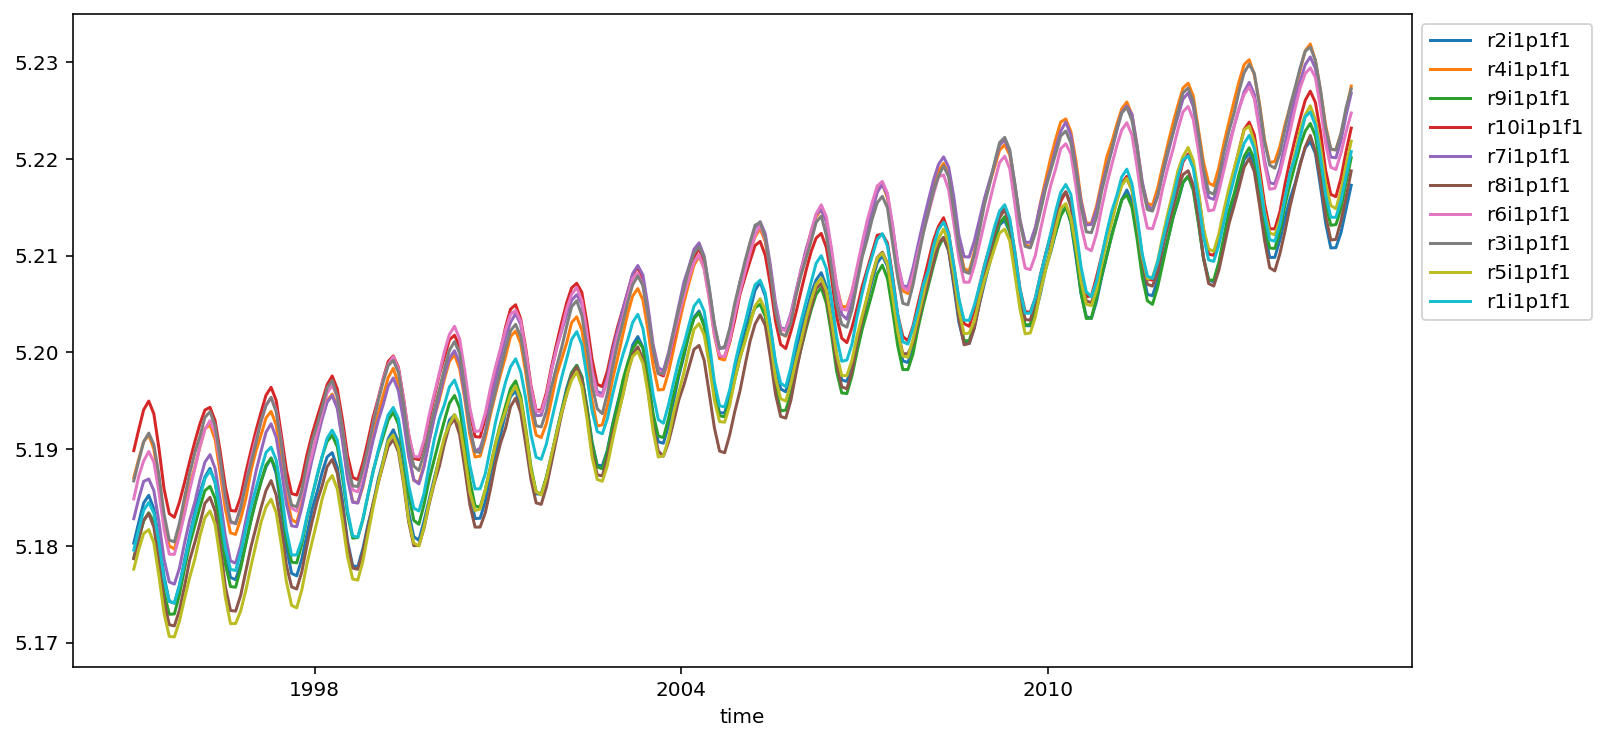

In [20]:
fig, ax = plt.subplots()
for i, ds in enumerate(ddict_matched_again.values()):
    # calculate the volume weighted mean ocean temperature
    vol = (ds.areacello * ds.thkcello)
    da = ds.thetao.isel(time=slice(-240, None)).weighted(vol.fillna(0)).mean(['x','y', 'lev']).squeeze().load()
    da.plot(ax=ax, color=f'C{i}', label=ds.attrs['variant_label'])
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

### Matching metrics when the exact data is not available

Sometimes, for whatever reason, the exact metric data for a certain field might not be available. But in the case of static data, like cell area, we can assume that as long as the model (`source_id`) and the grid configuration (`grid_label`) are the same, we can use the cell area for all members.

> Always check if these assumptions work in your case!

Within the [pangeo cmip6 catalog](https://pangeo-data.github.io/pangeo-cmip6-cloud/) there is one example of such a case for the `FGOALS-f3-L` model.

In [21]:
cat_data = col.search(source_id='FGOALS-f3-L', variable_id='thetao', experiment_id=experiment_id, grid_label='gn', table_id='Omon')
ddict = cat_data.to_dataset_dict(**kwargs)
cat_metric = col.search(source_id='FGOALS-f3-L', variable_id='areacello', experiment_id='historical', grid_label='gn')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


In [22]:
list(ddict.keys())

['CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r2i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008',
 'CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Omon/thetao/gn/v20190822/.nan.20190822',
 'CMIP.CAS.FGOALS-f3-L.historical.r3i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r3i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008']

In [23]:
list(ddict_metrics.keys())

['CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Ofx/areacello/gn/v20190918/.nan.20190918']

We can see that there are three members and only one of them has output for the cell area. 

By default `match_metrics` will use any available metric data that has the same `source_id` and `grid_label` attributes.

In [24]:
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'])

In [25]:
ds = ddict_matched['CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r2i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008']
ds

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 30, time: 1980, x: 360, y: 218)
Coordinates:
  * x            (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * y            (y) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
    lat          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * lev          (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * time         (time) object 1850-01-16 13:00:00.000007 ... 2014-12-16 12:0...
    time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * bnds         (bnds) int64 0 1
    areacello    (y, x) float32 dask.array<chunksize=(218, 360), meta=np.ndarray>
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(5, 30, 218, 360), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    NCO:                     netCDF Operators version 4.8.1 (Homepage = http:...
    activity_id:             CMIP
    branch_method:           Spin-up documentation
    branch_time_in_child:    674885.0
    branch_time_in_parent:   236885.0
    cmor_version:            3.4.0
    contact:                 Yongqiang Yu(yyq@lasg.iap.ac.cn)
    creation_date:           2019-10-07T20:29:01Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CAS.FGOALS-...
    grid:                    gs1x1
    grid_label:              gn
    history:                 Thu Nov 14 10:13:24 2019: ncatted -O -a license,...
    initialization_index:    1
    institution:             Chinese Academy of Sciences, Beijing 100029, China
    institution_id:          CAS
    license:                 CMIP6 model data produced by LASG, Institute of ...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        FGOALS-f3-L
    parent_time_units:       days since 0001-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       2
    realm:                   ocean
    references:              Model described by Yu et al.2019,
    run_variant:             forcing: black carbon aerosol only
    source:                  FGOALS-f3-L (2017): \naerosol: none\natmos: FAMI...
    source_id:               FGOALS-f3-L
    source_type:             AOGCM
    status:                  2020-12-20;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(09 May 2019) MD5:cde930676e68ac67...
    title:                   FGOALS-f3-L output prepared for CMIP6
    tracking_id:             hdl:21.14100/425a2350-df4c-4657-9b9d-5717e8cd983...
    variable_id:             thetao
    variant_label:           r2i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/425a2350-df4c-4657-9b9d-5717e8cd983...
    version_id:              v20191008
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.th...

You can see that even the other members have an `areacello` coordinate now. The attributes of the dataarray give some hints where this data was coming from

In [26]:
ds.areacello.attrs

{'cell_methods': 'area: sum',
 'comment': 'Horizontal area of ocean grid cells',
 'long_name': 'Grid-Cell Area for Ocean Variables',
 'standard_name': 'cell_area',
 'units': 'm2',
 'original_key': 'CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Ofx/areacello/gn/v20190918/.nan.20190918',
 'parsed_with': 'cmip6_preprocessing/postprocessing/parse_metric'}

The `original_key` field preserves the dictionary key of `ddict_metrics`, which in this case has all the information to find the actual source file. 

> If you are using this withouth [intake-esm]() your keys might be different and this output might be less useful.

You have fine-grained control over which datasets attributes are used for the matching between datasets and metrics.

For example, adding `variant_label` to the list of matched attributes, metrics will only be parse for dataset/metric pairs that have the exact same `variant_label`.

In [27]:
ddict_matched_strict = match_metrics(ddict, ddict_metrics, ['areacello'], match_attrs=['source_id', 'grid_label', 'variant_label'])

ds_strict = ddict_matched_strict['CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r2i1p1f1/Omon/thetao/gn/v20191008/.nan.20191008']
ds_strict

/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:126: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")


<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 30, time: 1980, x: 360, y: 218)
Coordinates:
  * x            (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * y            (y) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
    lat          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * lev          (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * time         (time) object 1850-01-16 13:00:00.000007 ... 2014-12-16 12:0...
    time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * bnds         (bnds) int64 0 1
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(5, 30, 218, 360), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    NCO:                     netCDF Operators version 4.8.1 (Homepage = http:...
    activity_id:             CMIP
    branch_method:           Spin-up documentation
    branch_time_in_child:    674885.0
    branch_time_in_parent:   236885.0
    cmor_version:            3.4.0
    contact:                 Yongqiang Yu(yyq@lasg.iap.ac.cn)
    creation_date:           2019-10-07T20:29:01Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CAS.FGOALS-...
    grid:                    gs1x1
    grid_label:              gn
    history:                 Thu Nov 14 10:13:24 2019: ncatted -O -a license,...
    initialization_index:    1
    institution:             Chinese Academy of Sciences, Beijing 100029, China
    institution_id:          CAS
    license:                 CMIP6 model data produced by LASG, Institute of ...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        FGOALS-f3-L
    parent_time_units:       days since 0001-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       2
    realm:                   ocean
    references:              Model described by Yu et al.2019,
    run_variant:             forcing: black carbon aerosol only
    source:                  FGOALS-f3-L (2017): \naerosol: none\natmos: FAMI...
    source_id:               FGOALS-f3-L
    source_type:             AOGCM
    status:                  2020-12-20;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(09 May 2019) MD5:cde930676e68ac67...
    title:                   FGOALS-f3-L output prepared for CMIP6
    tracking_id:             hdl:21.14100/425a2350-df4c-4657-9b9d-5717e8cd983...
    variable_id:             thetao
    variant_label:           r2i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/425a2350-df4c-4657-9b9d-5717e8cd983...
    version_id:              v20191008
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CAS.FGOALS-f3-L.historical.r2i1p1f1.Omon.th...

The one member that has an exact matched metric will still get it.

In [28]:
ds_strict_matched = ddict_matched_strict['CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historical/r1i1p1f1/Omon/thetao/gn/v20190822/.nan.20190822']
ds_strict_matched

<xarray.Dataset>
Dimensions:      (bnds: 2, lev: 30, time: 1980, x: 360, y: 218)
Coordinates:
  * x            (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * y            (y) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
    lat          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * lev          (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(218, 360), meta=np.ndarray>
  * time         (time) object 1850-01-16 13:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * bnds         (bnds) int64 0 1
    areacello    (y, x) float32 dask.array<chunksize=(218, 360), meta=np.ndarray>
Data variables:
    thetao       (time, lev, y, x) float32 dask.array<chunksize=(10, 30, 218, 360), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           Spin-up documentation
    branch_time_in_child:    674885.0
    branch_time_in_parent:   218635.0
    cmor_version:            3.4.0
    contact:                 Yongqiang Yu(yyq@lasg.iap.ac.cn)
    creation_date:           2019-08-22T15:40:13Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacello volcello
    forcing_index:           1
    frequency:               mon
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CAS.FGOALS-...
    grid:                    gs1x1
    grid_label:              gn
    history:                 2019-08-22T13:32:56Z ;rewrote data to be consist...
    initialization_index:    1
    institution:             Chinese Academy of Sciences, Beijing 100029, China
    institution_id:          CAS
    license:                 CMIP6 model data produced by Lawrence Livermore ...
    mip_era:                 CMIP6
    nominal_resolution:      100 km
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        FGOALS-f3-L
    parent_time_units:       days since 0001-01-01
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   ocean
    references:              Model described by Yu et al.2019,
    run_variant:             forcing: black carbon aerosol only
    source:                  FGOALS-f3-L (2017): \naerosol: none\natmos: FAMI...
    source_id:               FGOALS-f3-L
    source_type:             AOGCM
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                Omon
    table_info:              Creation Date:(09 May 2019) MD5:cde930676e68ac67...
    title:                   FGOALS-f3-L output prepared for CMIP6
    tracking_id:             hdl:21.14100/1cddc583-15f9-4315-b09b-1bc2cef6198...
    variable_id:             thetao
    variant_label:           r1i1p1f1
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/1cddc583-15f9-4315-b09b-1bc2cef6198...
    version_id:              v20190822
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CAS.FGOALS-f3-L.historical.r1i1p1f1.Omon.th...

You can see that the `r2i1p1f1` member was not matched, while `r1i1p1f1` was.

### Putting it all together

Ok it is time for a more high level example! 


Lets look at the global mean surface temperature for **ALL** available models, not just one.
The process is pretty much exactly the same, you only have to modify your initial `.search()` query for both the data and the metrics.

> I temporarily had to exclude a single member, due to a bug with intake-esm (see [here](https://github.com/intake/intake-esm/issues/331) for details).

In [29]:
experiment_id = 'ssp585'
cat_data = col.search(variable_id='tos', experiment_id=experiment_id, grid_label='gn', table_id='Omon')

##### remove a single store
# see https://github.com/intake/intake-esm/issues/246 for details on how to modify the dataframe
df = cat_data.df
drop_idx = cat_data.df.index[cat_data.df['zstore'].str.contains('ScenarioMIP.CCCma.CanESM5.ssp585.r9i1p1f1.Omon.tos.gn')]
df = df.drop(drop_idx)
cat_data = cat_data.from_df(df=df, esmcol_data=cat_data.esmcol_data)
#####

ddict = cat_data.to_dataset_dict(**kwargs)
cat_metric = col.search(variable_id='areacello', experiment_id=experiment_id, grid_label='gn')
ddict_metrics = cat_metric.to_dataset_dict(**kwargs)
ddict_matched = match_metrics(ddict, ddict_metrics, ['areacello'], print_statistics=True)

# remove the datasets where the parsing was unsuccesful
ddict_matched_filtered = {k:ds for k,ds in ddict_matched.items() if 'areacello' in ds.variables}


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Processed 272 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 239}
No match found:{'areacello': 33}


/Users/juliusbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:126: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")


We have 272 datasets to start with, only 184 area outputs, but we were able to match 239 of the datasets with a metric! The ones without metrics needed to be removed for plotting.

> Executing this plot takes a while. As always, ☕️ time

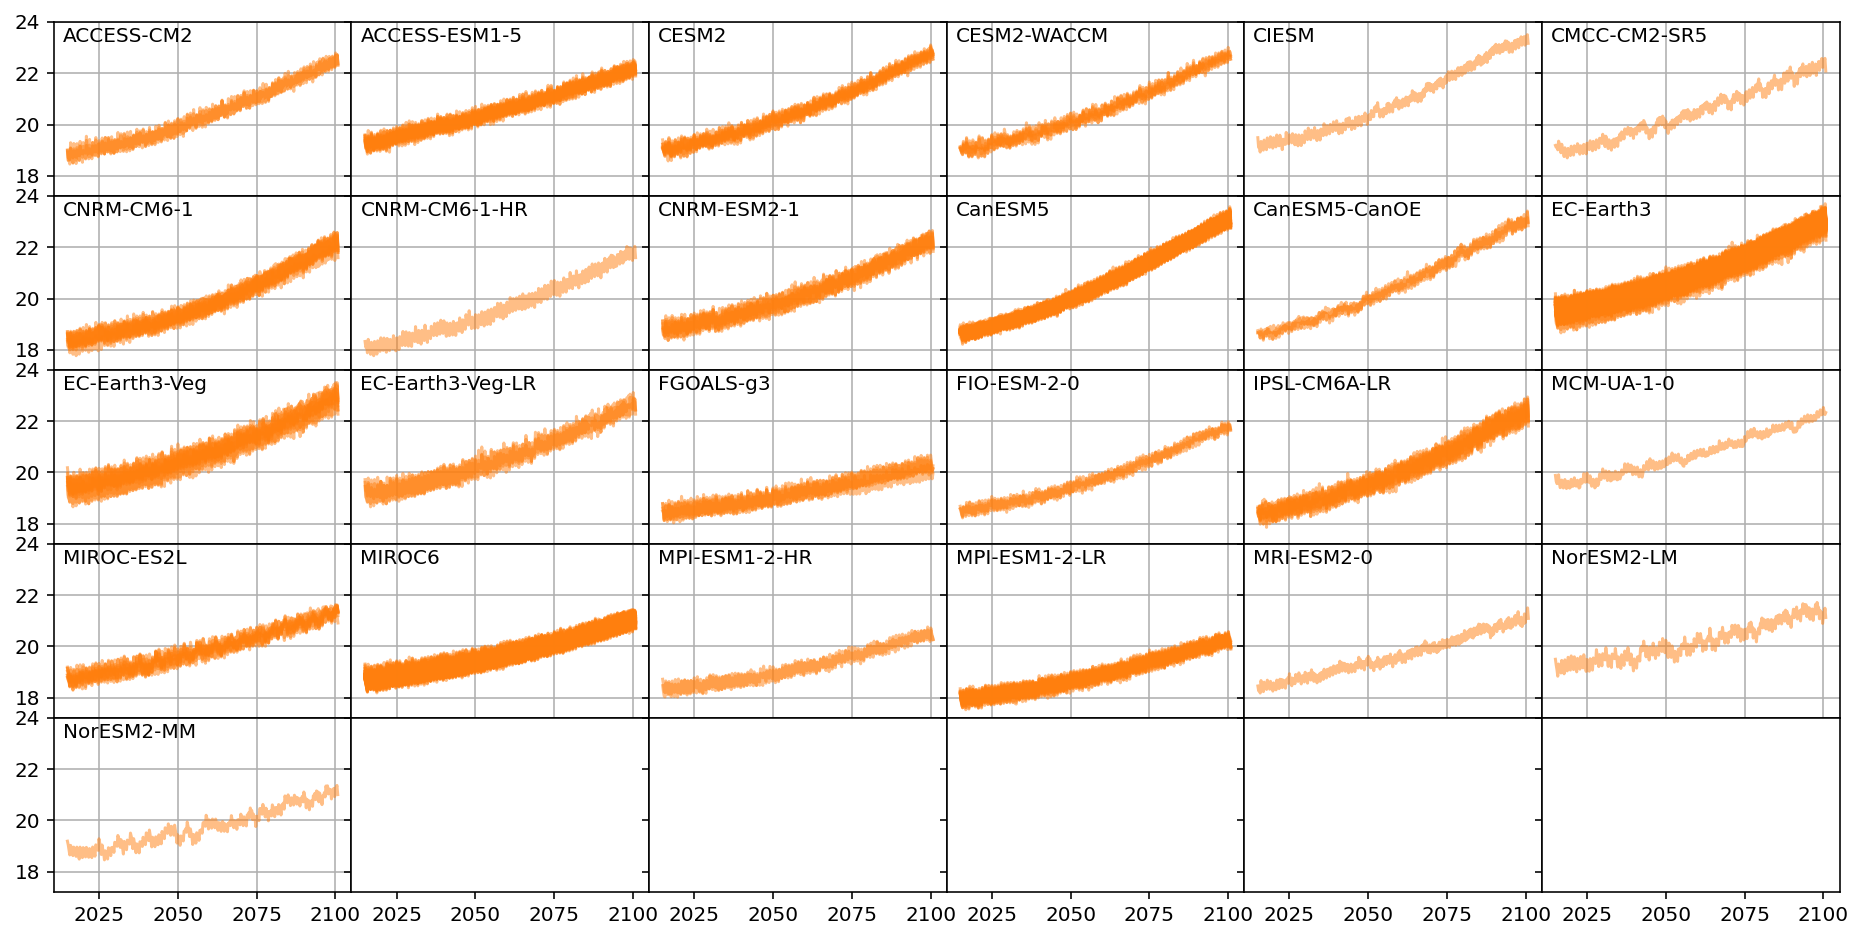

In [42]:
models = np.sort(cat_metric.df['source_id'].unique())
fig, axarr = plt.subplots(ncols=6, nrows=5, figsize=[16, 8], sharex=True, sharey=True)
for model, ax in zip(models, axarr.flat):
    ddict_model = {k:ds for k,ds in ddict_matched_filtered.items() if model in k}
    for i, ds in enumerate(ddict_model.values()):
        pass
        # calculate the area weighted mean surface ocean temperature
        da = ds.tos.sel(time=slice('2000', '2100')).weighted(ds.areacello.fillna(0)).mean(['x','y', 'lev']).squeeze().load()
        # resample to 3month averages
        da = da.resample(time='3MS').mean()
        da.plot(ax=ax, color=f'C{1}', label=ds.attrs['variant_label'], alpha=0.5)
    ax.text(0.03,0.97,model,ha='left',va='top', transform=ax.transAxes)
    ax.set_xlabel('')
    ax.grid()
fig.subplots_adjust(hspace=0, wspace=0)

Some interesting differences between models in terms of the mean temperature at the end of the century, but also in terms of variability.

I that if you are trying to work with many different models and grids this should make your life a little bit easier.

![](https://media.giphy.com/media/xUA7aNKumDkMaGDgn6/giphy.gif)